In [26]:
# ==========================================================
# Evaluation script: Surface code d=3, 5, 7, 9 (Astra GNN decoder)
# - Rebuilds code + GNN with same hyperparams as training
# - Loads checkpoint
# - Sweeps over PER and computes LER via logical_error_rate
# - Optional stub for BP+OSD baseline via PanQEC
# ==========================================================

import os
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from panqec.codes import surface_2d
from panqec.error_models import PauliErrorModel
from panqec.decoders import BeliefPropagationOSDDecoder, MatchingDecoder
from fnn_model import FNNDecoder
from fnn_data import make_fnn_dataset


from ldpc.mod2 import nullspace

from panq_functions import (
    GNNDecoder,
    collate,
    generate_syndrome_error_volume,
    adapt_trainset,
    logical_error_rate,
    fraction_of_solved_puzzles,
    surface_code_edges,
    load_model,
)

# ------------------------------------------
# Device selection: MPS (Mac GPU)  → CPU
# ------------------------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

# ==========================================================
# Parameters (must match training!)
# ==========================================================

error_model_name = "DP"
if error_model_name == "X":
    error_model = PauliErrorModel(1, 0.0, 0)
elif error_model_name == "Z":
    error_model = PauliErrorModel(0, 0.0, 1)
elif error_model_name == "XZ":
    error_model = PauliErrorModel(0.5, 0.0, 0.5)
elif error_model_name == "DP":
    error_model = PauliErrorModel(0.34, 0.32, 0.34)

distances = [3, 5, 7, 9, 11]
p_list = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16]

n_node_inputs = 4
n_node_outputs = 4
n_iters = 3
n_node_features = 50
n_edge_features = 50

msg_net_size = 512
msg_net_dropout_p = 0.05
gru_dropout_p = 0.05

# test samples for Astra per (d, p)
N_TEST = 1000

# MC samples for BP-OSD and MWPM per (d, p)
N_MC = 1000

MODEL_PATHS = {
    3: "trained_models/d3_DP_best.pth",
    5: "trained_models/d5_DP_best.pth",
    7: "trained_models/d7_DP_best.pth",
    9: "trained_models/d9_DP_best.pth",
    11: "trained_models/d11_DP_best.pth"
}
for d in distances:
    if not os.path.isfile(MODEL_PATHS[d]):
        print(f"WARNING: model path not found for d={d}: {MODEL_PATHS[d]}")
# =====================================================
# Helper: estimate LER for a classical decoder
# =====================================================

def estimate_ler_decoder(decoder, code, error_model, p, n_samples=10_000, rng=None):
    """
    Monte Carlo estimate of total failure rate for a PanQEC decoder.
    Failure = residual logical OR residual syndrome.
    """
    if rng is None:
        rng = np.random.default_rng()

    failures = 0
    for _ in range(n_samples):
        error = error_model.generate(code, p, rng=rng)
        syndrome = code.measure_syndrome(error)
        correction = decoder.decode(syndrome)
        total = (error + correction) % 2

        in_codespace = code.in_codespace(total)
        is_logical = code.is_logical_error(total)

        if (not in_codespace) or is_logical:
            failures += 1

    return failures / n_samples

# =====================================================
# Helper: estimate LER for a FNN decoder
# =====================================================
def estimate_ler_fnn(model, code, error_model, p, n_samples, device, rng=None):
    """
    Estimates total failure rate (logical OR residual syndrome) for FNN decoder.
    """
    if rng is None:
        rng = np.random.default_rng()

     # per-qubit Pauli probabilities for this p (arrays)
    pi_arr, px_arr, py_arr, pz_arr = error_model.probability_distribution(code, p)

    # Our FNN data generator assumes IID per qubit → use scalars
    pX = float(px_arr[0])
    pY = float(py_arr[0])
    pZ = float(pz_arr[0])

    # make dataset in one shot
    X_synd, eX_true, eZ_true = make_fnn_dataset(code, pX, pY, pZ, n_samples, device=device)

    model.eval()
    with torch.no_grad():
        eX_logits, eZ_logits = model(X_synd)
        eX_hat = (torch.sigmoid(eX_logits) > 0.5).cpu().numpy().astype(int)
        eZ_hat = (torch.sigmoid(eZ_logits) > 0.5).cpu().numpy().astype(int)

    # turn X/Z into PanQEC's 2n-bit representation
    true_errors   = np.concatenate([eX_true, eZ_true], axis=1)      # [N, 2n]
    corr_from_fnn = np.concatenate([eX_hat,  eZ_hat],  axis=1)      # [N, 2n]
    residual      = (true_errors + corr_from_fnn) % 2

    failures = 0
    for r in residual:
        in_codespace = code.in_codespace(r)
        is_logical   = code.is_logical_error(r)
        if (not in_codespace) or is_logical:
            failures += 1

    return failures / n_samples

Using device: mps


In [27]:
# =====================================================
# Main evaluation
# =====================================================

astra_ler = {d: [] for d in distances}
bp_ler    = {d: [] for d in distances}
mwpm_ler  = {d: [] for d in distances}
fnn_ler = {d: [] for d in distances}

for d in distances:
    print("\n======================================")
    print(f"Evaluating distance d = {d}")
    print("======================================")

    # ---------- code & GNN ----------
    code = surface_2d.RotatedPlanar2DCode(d)

    gnn = GNNDecoder(
        dist=d,
        n_node_inputs=n_node_inputs,
        n_node_outputs=n_node_outputs,
        n_iters=n_iters,
        n_node_features=n_node_features,
        n_edge_features=n_edge_features,
        msg_net_size=msg_net_size,
        msg_net_dropout_p=msg_net_dropout_p,
        gru_dropout_p=gru_dropout_p
    ).to(device)

    src, tgt = surface_code_edges(code)
    GNNDecoder.surface_code_edges = (
        torch.LongTensor(src),
        torch.LongTensor(tgt),
    )
    GNNDecoder.device = device

    load_model(gnn, MODEL_PATHS[d], device)
    gnn.eval()

    # ---------- FNN decoder ----------
    n_qubits = code.n
    synd_dim = code.Hx.shape[0] + code.Hz.shape[0]

    fnn = FNNDecoder(synd_dim, n_qubits).to(device)
    fnn.load_state_dict(torch.load(f"trained_models/fnn_d{d}_best.pth",
                                   map_location=device))
    fnn.eval()

    for p in p_list:
        ...
        # Astra, BP-OSD, MWPM already computed

        ler_fnn = estimate_ler_fnn(
            fnn, code, error_model, p, n_samples=N_MC, device=device
        )
        fnn_ler[d].append(ler_fnn)

    # ---------- BP+OSD & MWPM decoders ----------
    bp_osd = BeliefPropagationOSDDecoder(
        code, error_model, error_rate=0.0,
        max_bp_iter=1000, channel_update=False,
        osd_order=10, bp_method="minimum_sum"
    )

    mwpm = MatchingDecoder(
        code, error_model, error_rate=0.0
    )

    # ---------- loop over physical error rates ----------
    for p in p_list:
        print(f"  p = {p:.3f}")

        # ===== Astra evaluation =====
        testset = adapt_trainset(
            generate_syndrome_error_volume(
                code,
                error_model=error_model,
                p=p,
                batch_size=N_TEST,
                for_training=False,
            ),
            code,
            num_classes=n_node_inputs,
            for_training=False,
        )
        testloader = DataLoader(
            testset,
            batch_size=512,
            collate_fn=collate,
            shuffle=False,
        )

        _, _, ler_tot = logical_error_rate(gnn, testloader, code)

        astra_ler[d].append(ler_tot)

        # ===== BP+OSD evaluation =====
        ler_bp = estimate_ler_decoder(bp_osd, code, error_model,
                                      p, n_samples=N_MC)
        bp_ler[d].append(ler_bp)

        # ===== MWPM evaluation =====
        ler_mwpm = estimate_ler_decoder(mwpm, code, error_model,
                                        p, n_samples=N_MC)
        mwpm_ler[d].append(ler_mwpm)


Evaluating distance d = 3
Model loaded from trained_models/d3_DP_best.pth.
  p = 0.060
  p = 0.080
  p = 0.100
  p = 0.120
  p = 0.140
  p = 0.160

Evaluating distance d = 5
Model loaded from trained_models/d5_DP_best.pth.
  p = 0.060
  p = 0.080
  p = 0.100
  p = 0.120
  p = 0.140
  p = 0.160

Evaluating distance d = 7
Model loaded from trained_models/d7_DP_best.pth.
  p = 0.060
  p = 0.080
  p = 0.100
  p = 0.120
  p = 0.140
  p = 0.160

Evaluating distance d = 9
Model loaded from trained_models/d9_DP_best.pth.
  p = 0.060
  p = 0.080
  p = 0.100
  p = 0.120
  p = 0.140
  p = 0.160

Evaluating distance d = 11
Model loaded from trained_models/d11_DP_best.pth.
  p = 0.060
  p = 0.080
  p = 0.100
  p = 0.120
  p = 0.140
  p = 0.160


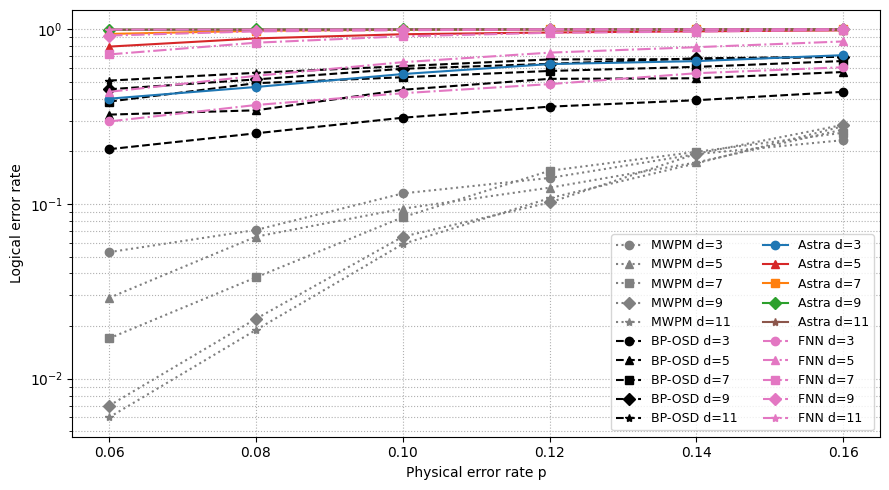

In [28]:
# =====================================================
# Plot: Astra vs BP+OSD vs MWPM
# =====================================================

plt.figure(figsize=(9, 5))

bp_markers = {3: 'o', 5: '^', 7: 's', 9: 'D', 11: '*'}
astra_colors = {
    3: 'tab:blue',
    5: 'tab:red',
    7: 'tab:orange',
    9: 'tab:green',
    11: 'tab:brown'
}

# --- MWPM (dotted gray) ---
for d in distances:
    plt.plot(
        p_list,
        mwpm_ler[d],
        linestyle=':',
        color='gray',
        marker=bp_markers[d],
        label=f"MWPM d={d}"
    )

# --- BP+OSD (dashed black) ---
for d in distances:
    plt.plot(
        p_list,
        bp_ler[d],
        linestyle='--',
        color='black',
        marker=bp_markers[d],
        label=f"BP-OSD d={d}"
    )

# --- Astra (solid colored) ---
for d in distances:
    plt.plot(
        p_list,
        astra_ler[d],
        linestyle='-',
        color=astra_colors[d],
        marker=bp_markers[d],
        label=f"Astra d={d}"
    )
# --- FNN (solid, different color family or markers) ---
for d in distances:
    plt.plot(
        p_list,
        fnn_ler[d],
        linestyle='-.',
        color='tab:pink',           # or a mapping by d
        marker=bp_markers[d],
        label=f"FNN d={d}"
    )
    
plt.yscale("log")
plt.xlabel("Physical error rate p")
plt.ylabel("Logical error rate")
plt.grid(True, which="both", ls=":")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


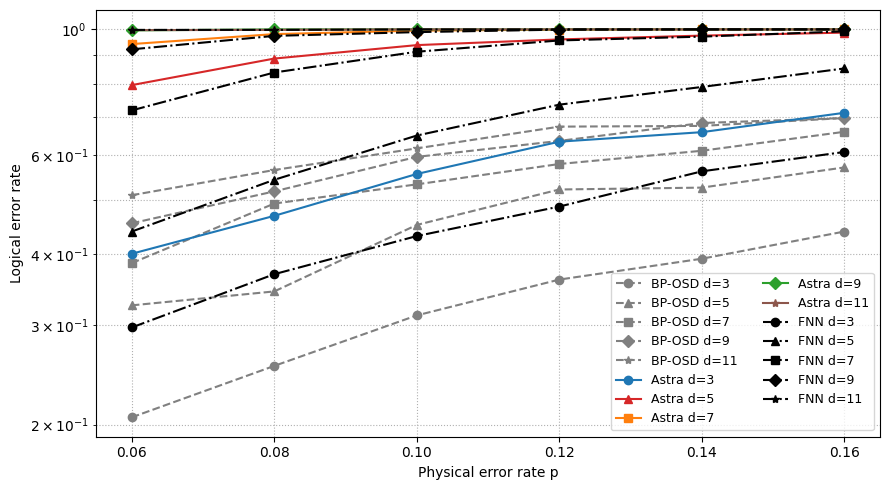

In [30]:
plt.figure(figsize=(9, 5))

bp_markers = {3: 'o', 5: '^', 7: 's', 9: 'D', 11: '*'}
astra_colors = {
    3: 'tab:blue',
    5: 'tab:red',
    7: 'tab:orange',
    9: 'tab:green',
    11: 'tab:brown'
}

# --- BP+OSD (dashed grey) ---
for d in distances:
    plt.plot(
        p_list,
        bp_ler[d],
        linestyle='--',
        color='grey',
        marker=bp_markers[d],
        label=f"BP-OSD d={d}"
    )

# --- Astra (solid colored) ---
for d in distances:
    plt.plot(
        p_list,
        astra_ler[d],
        linestyle='-',
        color=astra_colors[d],
        marker=bp_markers[d],
        label=f"Astra d={d}"
    )
# --- FNN (solid black) ---
for d in distances:
    plt.plot(
        p_list,
        fnn_ler[d],
        linestyle='-.',
        color='black',           # or a mapping by d
        marker=bp_markers[d],
        label=f"FNN d={d}"
    )
    
plt.yscale("log")
plt.xlabel("Physical error rate p")
plt.ylabel("Logical error rate")
plt.grid(True, which="both", ls=":")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
